# **MNIST Teacher Student MLP**


En este notebook se creara un red neuronal utilizando la arquitectura de MLP(Multilayer Percepetron).

In [3]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np 
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

## Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Knowledge Distillation
from src.distillationClassKeras import *

## Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

## Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

## Training
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.optimizers import RMSprop

In [5]:
(train_data, train_labels) , (test_data, test_labels) = mnist.load_data()

In [6]:
train_data.shape 

(60000, 28, 28)

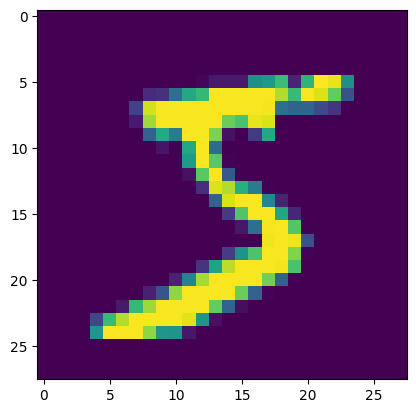

In [7]:
plt.imshow(train_data[0]) #mostrar la primera imagen



## Teacher Training

Los hiperparámetros que definen la arquitectura del modelo *Teacher* son:

* Learning rate
* Número de neuronas
* Número de filtros


In [8]:
# Define the hyperparameters for the teacher model
lr = 0.01
neurons_teacher = [124, 64]

### Topologia del modelo Teacher

El input esta dado por la forma de la imagen del mnist (28,28,1) y ofrece una salida de 10, que corresponde a los numeros del 0 al 9

In [9]:
def teacher_topology(bestHP):

    teacher = keras.models.Sequential(
        [
            keras.Input(shape=(28*28,)),
            

            Dense(bestHP[0], activation='relu', kernel_regularizer=l2(0.001), name='fc1'),
            Dense(bestHP[1], activation='relu', kernel_regularizer=l2(0.001), name='fc2'),
            Dropout(0.1, name='drop1'),
            
            Dense(10, activation='softmax', name='output'),
        ],
        name="teacher_MLP",
    )

    teacher.summary()
    return teacher


Para la construccion del modelo teacher, se utiliza el optimizador *Adam* que coge de parametro el learning rate, y utilizamos la funcion de perdidas *categorical_crossentropy* y metricas *accuaracy*

In [10]:
 
def build_teacher(neurons_teacher):

    model = teacher_topology(neurons_teacher)
       
    opt = Adam(lr)
    
    model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    return model

In [11]:
teacher_model = build_teacher(neurons_teacher) 

Model: "teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 124)               97340     
                                                                 
 fc2 (Dense)                 (None, 64)                8000      
                                                                 
 drop1 (Dropout)             (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 105,990
Trainable params: 105,990
Non-trainable params: 0
_________________________________________________________________


2025-12-09 14:34:51.461627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-09 14:34:51.461688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pinpatom
2025-12-09 14:34:51.461704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pinpatom
2025-12-09 14:34:51.461948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 580.82.7
2025-12-09 14:34:51.462012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 580.82.7
2025-12-09 14:34:51.462028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 580.82.7


In [12]:
#entrenando el modelo
#cambiando´rimero la forma de los datos
x_train = train_data.reshape((60000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_train = x_train.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

x_test = test_data.reshape((10000,28*28))#bajar a dos dimencionas para facilitar la red neuronal
x_test = x_test.astype('float32')/255 #es mas facil manjear float y /255 es el numero maximo para que me de numero de 0 a 1

In [13]:
x_train = train_data.astype("float32") / 255.0
x_test  = test_data.astype("float32") / 255.0

In [14]:
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test  = x_test.reshape((x_test.shape[0], 28*28))

In [15]:
#hacer una transformacion a los labels

y_train = to_categorical(train_labels, num_classes=10)
y_test  = to_categorical(test_labels, num_classes=10)

In [16]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,     # 10% validación
    random_state=42,
    shuffle=True
)

In [16]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.4, patience=3, verbose=1)
            ] 

history_teacher  = teacher_model.fit(x=x_train, y=y_train,
                  validation_data=(x_test, y_test), 
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-09 09:26:21.371378: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


844/844 [==============================] - 10s 10ms/step - loss: 0.5592 - accuracy: 0.9000 - val_loss: 0.4647 - val_accuracy: 0.9243 - lr: 0.0100
Epoch 2/32
844/844 [==============================] - 9s 10ms/step - loss: 0.4640 - accuracy: 0.9219 - val_loss: 0.4480 - val_accuracy: 0.9210 - lr: 0.0100
Epoch 3/32
844/844 [==============================] - 9s 10ms/step - loss: 0.4400 - accuracy: 0.9250 - val_loss: 0.4444 - val_accuracy: 0.9166 - lr: 0.0100
Epoch 4/32
844/844 [==============================] - 8s 10ms/step - loss: 0.4280 - accuracy: 0.9248 - val_loss: 0.4072 - val_accuracy: 0.9327 - lr: 0.0100
Epoch 5/32
844/844 [==============================] - 9s 10ms/step - loss: 0.4138 - accuracy: 0.9277 - val_loss: 0.3468 - val_accuracy: 0.9405 - lr: 0.0100
Epoch 6/32
844/844 [==============================] - 8s 10ms/step - loss: 0.4229 - accuracy: 0.9251 - val_loss: 0.4158 - val_accuracy: 0.9275 - lr: 0.0100
Epoch 7/32
844/844 [==============================] - 9s 10ms/step - loss:

### **Conceptos clave**

En aprendizaje automático, la *accuracy* (precisión) mide qué proporción de predicciones son correctas. Durante el entrenamiento se suelen mostrar dos curvas: la precisión sobre los datos de **entrenamiento**, que indica qué tan bien el modelo aprende de los ejemplos que ya ha visto, y la precisión de **validación**, que muestra qué tan bien generaliza a datos nuevos que no vio durante el entrenamiento. Si ambas curvas suben y se mantienen cercanas, significa que el modelo está aprendiendo correctamente y no está memorizando los datos (sobreajuste). Por otro lado, si la precisión de entrenamiento sube mientras la de validación baja o se estanca, puede indicar problemas de *overfitting*.




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


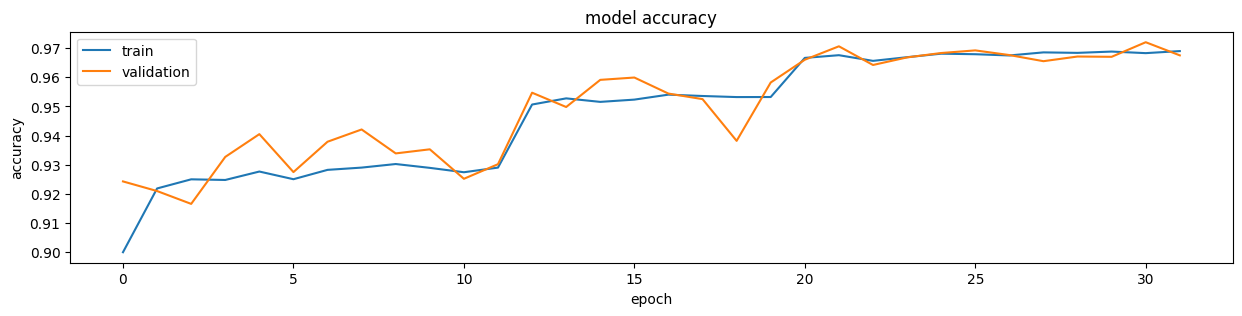

<Figure size 640x480 with 0 Axes>

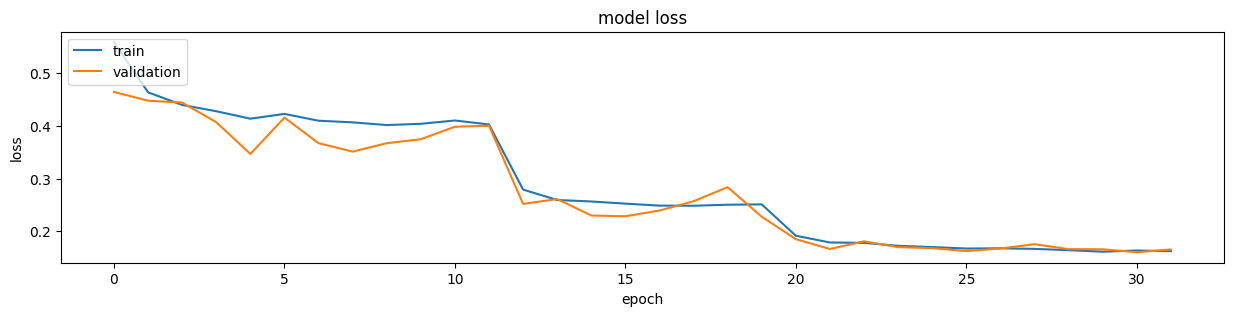

In [17]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Qué es una matriz de confusión**

Una matriz de confusión es una herramienta que permite evaluar el rendimiento de un modelo de clasificación mostrando cuántos ejemplos fueron predichos correctamente y cuántos fueron confundidos con otras clases. Cada fila representa la **etiqueta verdadera**, mientras que cada columna representa la **predicción del modelo**. Los valores en la diagonal indican aciertos: cuantos más valores altos haya allí, mejor es el rendimiento. Los valores fuera de la diagonal indican errores y muestran específicamente qué clases se confunden entre sí, lo que ayuda a identificar patrones de fallo del modelo.



313/313 [==============================] - 1s 2ms/step


<Figure size 700x700 with 0 Axes>

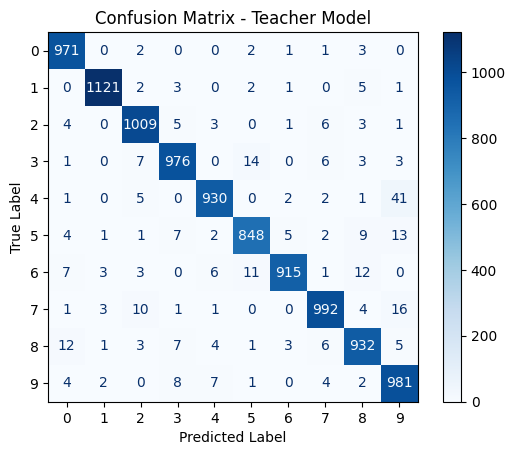

In [18]:
# 1. Predecir probabilidades
y_pred_probs = teacher_model.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
teacher_model.save('models/MLP/teacherModelMnistMLP.h5')

# **Pruning**


El pruning es una técnica utilizada para reducir el tamaño y la complejidad de un modelo de deep learning mediante la eliminación de pesos o neuronas que se consideran poco relevantes. El objetivo principal es mejorar la eficiencia del modelo reduciendo el consumo de memoria y acelerando la inferencia, todo ello sin afectar de manera significativa la precisión final del modelo.



In [20]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.5

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

callbacks.append(pruning_callbacks.UpdatePruningStep())

In [21]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [22]:
history_P  = modelP.fit(x=x_train, y=y_train,
                  validation_split = val_split,
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-09 09:30:38.148994: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135475200 exceeds 10% of free system memory.


675/675 [==============================] - 11s 11ms/step - loss: 0.1455 - accuracy: 0.9732 - val_loss: 0.1321 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 2/32
675/675 [==============================] - 7s 11ms/step - loss: 0.1411 - accuracy: 0.9738 - val_loss: 0.1389 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 3/32
675/675 [==============================] - 8s 12ms/step - loss: 0.1389 - accuracy: 0.9741 - val_loss: 0.1425 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 4/32
675/675 [==============================] - 8s 12ms/step - loss: 0.1377 - accuracy: 0.9750 - val_loss: 0.1487 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 5/32
675/675 [==============================] - 7s 11ms/step - loss: 0.1394 - accuracy: 0.9741 - val_loss: 0.1439 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 6/32
675/675 [==============================] - 7s 11ms/step - loss: 0.1375 - accuracy: 0.9738 - val_loss: 0.1434 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 7/32
675/675 [==============================] - 8s 11ms/step - loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


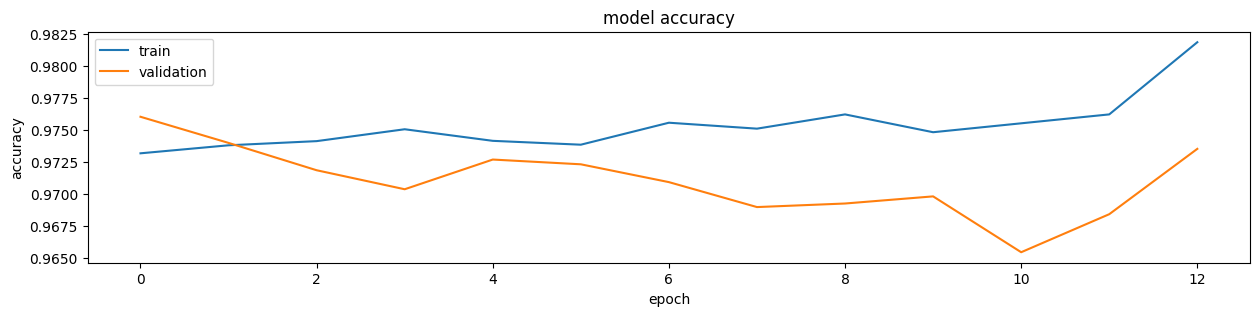

<Figure size 640x480 with 0 Axes>

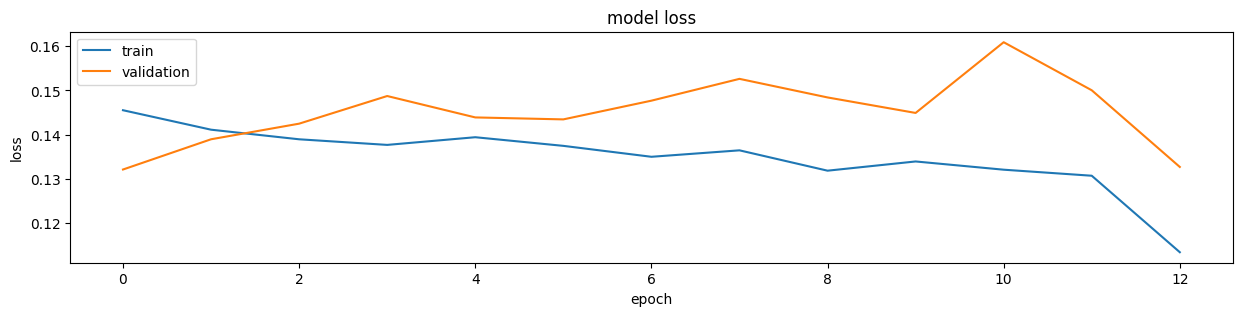

In [23]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

313/313 [==============================] - 1s 2ms/step


<Figure size 700x700 with 0 Axes>

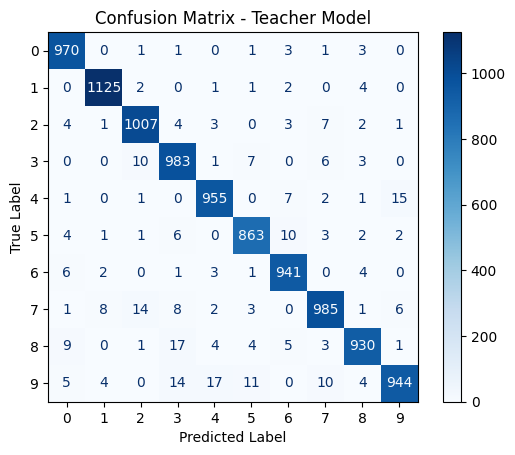

In [24]:
# 1. Predecir probabilidades
y_pred_probs =modelP.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
modelP.save('models/MLP/teacherModelMnistMLP_pruned.h5')

### **Quantization**


Es una técnica que reduce la precisión numérica de los parámetros de una red neuronal al convertir valores en punto flotante de **32 bits** a representaciones más pequeñas, como **16 bits** o incluso **8 bits**. El objetivo es disminuir el tamaño del modelo, mejorar la velocidad de inferencia y permitir que funcione en dispositivos con recursos limitados.

Para este caso se utilizan **quantization-aware training** (QAT) y **quantization-aware pruning** (QAP):

* **QAT** es una técnica en la que el modelo aprende a adaptarse a la cuantización durante el entrenamiento. En lugar de entrenar el modelo por completo y cuantificarlo al final, la cuantización se introduce desde el proceso de entrenamiento para que el modelo aprenda a trabajar bajo esa restricción numérica.

* **QAP** combina el *pruning* con QAT. La idea es reducir el modelo a través de poda antes de cuantificarlo, logrando una red más eficiente en tamaño y velocidad sin sacrificar la precisión.




In [26]:
# Estrategia de cuantización – 8 bits
kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8,4,alpha=1)"
activationQ = "quantized_bits(8,4)"

modelQAT = Sequential(
    [

        keras.Input(shape=(28*28,)),

        # Capa 1 (equivalente a fc1)
        QDense(neurons_teacher[0], 
               name='fc1',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation(activation=activationQ, name='relu1'),

        # Capa 2 (equivalente a fc2)
        QDense(neurons_teacher[1],
               name='fc2',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation(activation=activationQ, name='relu2'),

        # Dropout igual que el teacher
        Dropout(0.1, name='drop1'),

        # Capa final softmax (no cuantizamos la activación de salida)
        QDense(10,
               name='output',
               kernel_quantizer=kernelQ,
               bias_quantizer=biasQ,
               kernel_initializer='lecun_uniform'),
        QActivation('softmax', name='softmax'),
    ],
    name="quantized_teacher_MLP",
)


/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [27]:
modelQAT.summary()

Model: "quantized_teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 124)               97340     
                                                                 
 relu1 (QActivation)         (None, 124)               0         
                                                                 
 fc2 (QDense)                (None, 64)                8000      
                                                                 
 relu2 (QActivation)         (None, 64)                0         
                                                                 
 drop1 (Dropout)             (None, 64)                0         
                                                                 
 output (QDense)             (None, 10)                650       
                                                                 
 softmax (QActivation)       (None, 10)      

In [28]:
# Model Training

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x=x_train, y=y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16


2025-12-09 09:32:25.037007: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135475200 exceeds 10% of free system memory.


1350/1350 [==============================] - 19s 12ms/step - loss: 0.9593 - accuracy: 0.7967 - val_loss: 0.5709 - val_accuracy: 0.8631
Epoch 2/16
1350/1350 [==============================] - 10s 8ms/step - loss: 0.6004 - accuracy: 0.8500 - val_loss: 0.5320 - val_accuracy: 0.8545
Epoch 3/16
1350/1350 [==============================] - 14s 10ms/step - loss: 0.5658 - accuracy: 0.8546 - val_loss: 0.4970 - val_accuracy: 0.8683
Epoch 4/16
1350/1350 [==============================] - 15s 11ms/step - loss: 0.5538 - accuracy: 0.8566 - val_loss: 0.4895 - val_accuracy: 0.8767
Epoch 5/16
1350/1350 [==============================] - 16s 12ms/step - loss: 0.5380 - accuracy: 0.8596 - val_loss: 0.4999 - val_accuracy: 0.8705
Epoch 6/16
1350/1350 [==============================] - 15s 11ms/step - loss: 0.5057 - accuracy: 0.8677 - val_loss: 0.4759 - val_accuracy: 0.8721
Epoch 7/16
1350/1350 [==============================] - 15s 11ms/step - loss: 0.5069 - accuracy: 0.8654 - val_loss: 0.4684 - val_accurac

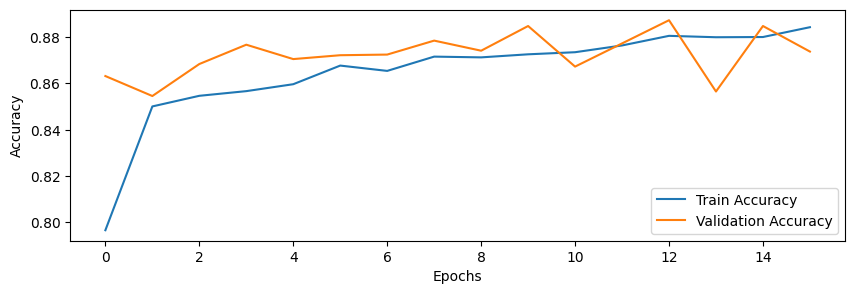

In [29]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyQAT.history['accuracy'], label='Train Accuracy')
plt.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


<Figure size 700x700 with 0 Axes>

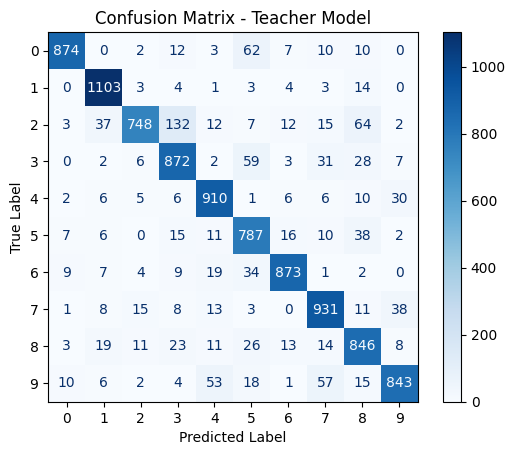

In [30]:
# 1. Predecir probabilidades
y_pred_probs =modelQAT.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [31]:
modelQAT.save('models/MLP/teacherModelQATMnistMLP.h5')

# **Student network** 

Para implementar un modelo de red neuronal en una FPGA, se reduce el tamaño del modelo *Teacher* creando un modelo *Student* mediante **Knowledge Distillation (KD)**. Este método consiste en transferir el conocimiento del modelo *Teacher* al *Student*, permitiendo que el modelo más pequeño mantenga un rendimiento similar al del modelo original.


In [32]:
lr = 0.01
neurons_student = [64,32]

In [33]:
def student_topology(neurons_student):
    
    '''
    Model to be trained. Defined with quantization strategies. 
    Input: hyperparams. (bestHP)
    Output: compressed model (studentQ_MLP). 

    '''
    ######## ---------------------------  Model definition - 1D STUDENT -----------------------------------------

    # Number of bits 
    ## 4-bits
    kernelQ_4b = "quantized_bits(4,2,alpha=1)"
    biasQ_4b = "quantized_bits(4,2,alpha=1)"
    activationQ_4b = 'quantized_bits(4, 0)'

    ## 8-bits
    kernelQ = "quantized_bits(8,4,alpha=1)"
    biasQ = "quantized_bits(8,4,alpha=1)"
    activationQ = 'quantized_bits(8)'
    
    ## 16-bits
    kernelQ_16b = "quantized_bits(16,6,alpha=1)"
    biasQ_16b = "quantized_bits(16,6,alpha=1)"
    activationQ_16b = 'quantized_bits(16)'
    
    studentQ_MLP = keras.Sequential(
        [
            Input(shape=(28*28,), name='inputLayer'),

            # Capa 1: equivalente a fc1 del teacher
            QDense(neurons_student[0],
                   kernel_quantizer=kernelQ,
                   bias_quantizer=biasQ,
                   kernel_initializer='lecun_uniform',
                   name='fc1'),
            QActivation(activation=activationQ, name='relu1'),

            # Capa 2: equivalente a fc2 del teacher
            QDense(neurons_student[1],
                   kernel_quantizer=kernelQ,
                   bias_quantizer=biasQ,
                   kernel_initializer='lecun_uniform',
                   name='fc2'),
            QActivation(activation=activationQ, name='relu2'),

            # Dropout igual al teacher
            Dropout(0.1, name='drop1'),

            # Capa final (10 clases, softmax)
            QDense(10,
                   kernel_quantizer=kernelQ_16b,
                   bias_quantizer=biasQ_16b,
                   kernel_initializer='lecun_uniform',
                   name='output'),
            Activation(activation='softmax', name='outputActivation')
        ],
        name="studentMLP",
    )


    return studentQ_MLP

In [34]:
def build_student(student_neurons):

    '''
    Model to be compressed. Defined with quantization strategies. 
    Input: hyperparams (student_neurons).
    Output: compressed model (studentQ). 

    '''
    
    qmodel = student_topology(student_neurons)

    # Pruning parameters 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
    }
    
    studentQ = prune.prune_low_magnitude(qmodel, **pruning_params)
    
    
    return studentQ

In [35]:
studentQ = build_student(neurons_student)

distilled_student = Distiller(student=studentQ, teacher=teacher_model)

adam = Adam(lr)

train_labels = np.argmax(y_train, axis=1)

distilled_student.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [36]:
callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, verbose=1),
                ]  

callbacks.append(pruning_callbacks.UpdatePruningStep())

history_studentQPKD = distilled_student.fit(x_train, train_labels, 
                               batch_size = 64, 
                               epochs= 32, 
                               validation_split=0.2,
                               callbacks = callbacks
                               )

Epoch 1/32


2025-12-09 09:36:22.774097: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 135475200 exceeds 10% of free system memory.
/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8542 - student_loss: 0.4848 - distillation_loss: 9.0920e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 12s 11ms/step - sparse_categorical_accuracy: 0.8544 - student_loss: 0.4849 - distillation_loss: 9.0776e-05 - val_sparse_categorical_accuracy: 0.8954 - val_student_loss: 0.4378 - lr: 0.0100
Epoch 2/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8950 - student_loss: 0.3725 - distillation_loss: 6.4126e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8950 - student_loss: 0.3726 - distillation_loss: 6.4165e-05 - val_sparse_categorical_accuracy: 0.9027 - val_student_loss: 0.3898 - lr: 0.0100
Epoch 3/32
671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8953 - student_loss: 0.3647 - distillation_loss: 6.2820e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8952 - student_loss: 0.3651 - distillation_loss: 6.2804e-05 - val_sparse_categorical_accuracy: 0.8987 - val_student_loss: 0.4155 - lr: 0.0100
Epoch 4/32
669/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8922 - student_loss: 0.3711 - distillation_loss: 6.4925e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8922 - student_loss: 0.3714 - distillation_loss: 6.4902e-05 - val_sparse_categorical_accuracy: 0.8959 - val_student_loss: 0.4262 - lr: 0.0100
Epoch 5/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8925 - student_loss: 0.3713 - distillation_loss: 6.4788e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8925 - student_loss: 0.3713 - distillation_loss: 6.4728e-05 - val_sparse_categorical_accuracy: 0.8943 - val_student_loss: 0.4147 - lr: 0.0100
Epoch 6/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8923 - student_loss: 0.3727 - distillation_loss: 6.5275e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 9s 13ms/step - sparse_categorical_accuracy: 0.8923 - student_loss: 0.3729 - distillation_loss: 6.5288e-05 - val_sparse_categorical_accuracy: 0.8905 - val_student_loss: 0.4085 - lr: 0.0100
Epoch 7/32
671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8917 - student_loss: 0.3776 - distillation_loss: 6.5765e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8918 - student_loss: 0.3772 - distillation_loss: 6.5843e-05 - val_sparse_categorical_accuracy: 0.8892 - val_student_loss: 0.4466 - lr: 0.0100
Epoch 8/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8905 - student_loss: 0.3778 - distillation_loss: 6.6572e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8905 - student_loss: 0.3777 - distillation_loss: 6.6580e-05 - val_sparse_categorical_accuracy: 0.8922 - val_student_loss: 0.4418 - lr: 0.0100
Epoch 9/32
671/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8867 - student_loss: 0.3921 - distillation_loss: 6.9527e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8867 - student_loss: 0.3921 - distillation_loss: 6.9589e-05 - val_sparse_categorical_accuracy: 0.8910 - val_student_loss: 0.3810 - lr: 0.0100
Epoch 10/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8857 - student_loss: 0.3962 - distillation_loss: 7.0146e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8858 - student_loss: 0.3958 - distillation_loss: 7.0063e-05 - val_sparse_categorical_accuracy: 0.8891 - val_student_loss: 0.4068 - lr: 0.0100
Epoch 11/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8825 - student_loss: 0.4060 - distillation_loss: 7.2586e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8825 - student_loss: 0.4060 - distillation_loss: 7.2623e-05 - val_sparse_categorical_accuracy: 0.8876 - val_student_loss: 0.4042 - lr: 0.0100
Epoch 12/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8795 - student_loss: 0.4112 - distillation_loss: 7.3677e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8794 - student_loss: 0.4109 - distillation_loss: 7.3678e-05 - val_sparse_categorical_accuracy: 0.8860 - val_student_loss: 0.4748 - lr: 0.0100
Epoch 13/32
670/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8789 - student_loss: 0.4175 - distillation_loss: 7.4796e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8788 - student_loss: 0.4177 - distillation_loss: 7.4858e-05 - val_sparse_categorical_accuracy: 0.8823 - val_student_loss: 0.4151 - lr: 0.0100
Epoch 14/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8802 - student_loss: 0.4134 - distillation_loss: 7.4170e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8801 - student_loss: 0.4134 - distillation_loss: 7.4249e-05 - val_sparse_categorical_accuracy: 0.8847 - val_student_loss: 0.4469 - lr: 0.0100
Epoch 15/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8776 - student_loss: 0.4177 - distillation_loss: 7.4821e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8777 - student_loss: 0.4174 - distillation_loss: 7.4786e-05 - val_sparse_categorical_accuracy: 0.8835 - val_student_loss: 0.4363 - lr: 0.0100
Epoch 16/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8759 - student_loss: 0.4222 - distillation_loss: 7.5817e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8759 - student_loss: 0.4221 - distillation_loss: 7.5854e-05 - val_sparse_categorical_accuracy: 0.8804 - val_student_loss: 0.3797 - lr: 0.0100
Epoch 17/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8772 - student_loss: 0.4230 - distillation_loss: 7.5845e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8772 - student_loss: 0.4238 - distillation_loss: 7.5890e-05 - val_sparse_categorical_accuracy: 0.8826 - val_student_loss: 0.4249 - lr: 0.0100
Epoch 18/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8776 - student_loss: 0.4227 - distillation_loss: 7.5266e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8776 - student_loss: 0.4227 - distillation_loss: 7.5261e-05 - val_sparse_categorical_accuracy: 0.8812 - val_student_loss: 0.4667 - lr: 0.0100
Epoch 19/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8771 - student_loss: 0.4210 - distillation_loss: 7.5755e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8771 - student_loss: 0.4205 - distillation_loss: 7.5703e-05 - val_sparse_categorical_accuracy: 0.8819 - val_student_loss: 0.3459 - lr: 0.0100
Epoch 20/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8777 - student_loss: 0.4203 - distillation_loss: 7.5606e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 9s 13ms/step - sparse_categorical_accuracy: 0.8778 - student_loss: 0.4202 - distillation_loss: 7.5596e-05 - val_sparse_categorical_accuracy: 0.8815 - val_student_loss: 0.3249 - lr: 0.0100
Epoch 21/32
672/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8780 - student_loss: 0.4196 - distillation_loss: 7.5712e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 11ms/step - sparse_categorical_accuracy: 0.8779 - student_loss: 0.4200 - distillation_loss: 7.5770e-05 - val_sparse_categorical_accuracy: 0.8774 - val_student_loss: 0.3640 - lr: 0.0100
Epoch 22/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8756 - student_loss: 0.4261 - distillation_loss: 7.6707e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8755 - student_loss: 0.4261 - distillation_loss: 7.6774e-05 - val_sparse_categorical_accuracy: 0.8755 - val_student_loss: 0.3961 - lr: 0.0100
Epoch 23/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8729 - student_loss: 0.4295 - distillation_loss: 7.8044e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 9s 13ms/step - sparse_categorical_accuracy: 0.8728 - student_loss: 0.4292 - distillation_loss: 7.7973e-05 - val_sparse_categorical_accuracy: 0.8753 - val_student_loss: 0.4992 - lr: 0.0100
Epoch 24/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8742 - student_loss: 0.4295 - distillation_loss: 7.7415e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 7s 11ms/step - sparse_categorical_accuracy: 0.8742 - student_loss: 0.4293 - distillation_loss: 7.7337e-05 - val_sparse_categorical_accuracy: 0.8769 - val_student_loss: 0.5127 - lr: 0.0100
Epoch 25/32
667/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8753 - student_loss: 0.4267 - distillation_loss: 7.7076e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 6s 9ms/step - sparse_categorical_accuracy: 0.8753 - student_loss: 0.4273 - distillation_loss: 7.7069e-05 - val_sparse_categorical_accuracy: 0.8736 - val_student_loss: 0.5003 - lr: 0.0100
Epoch 26/32
673/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8746 - student_loss: 0.4280 - distillation_loss: 7.7159e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 5s 8ms/step - sparse_categorical_accuracy: 0.8746 - student_loss: 0.4274 - distillation_loss: 7.7138e-05 - val_sparse_categorical_accuracy: 0.8776 - val_student_loss: 0.4756 - lr: 0.0100
Epoch 27/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8760 - student_loss: 0.4283 - distillation_loss: 7.7021e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 5s 8ms/step - sparse_categorical_accuracy: 0.8760 - student_loss: 0.4285 - distillation_loss: 7.7043e-05 - val_sparse_categorical_accuracy: 0.8801 - val_student_loss: 0.4936 - lr: 0.0100
Epoch 28/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8748 - student_loss: 0.4300 - distillation_loss: 7.7658e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8748 - student_loss: 0.4300 - distillation_loss: 7.7677e-05 - val_sparse_categorical_accuracy: 0.8780 - val_student_loss: 0.4881 - lr: 0.0100
Epoch 29/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8751 - student_loss: 0.4293 - distillation_loss: 7.7185e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8752 - student_loss: 0.4296 - distillation_loss: 7.7150e-05 - val_sparse_categorical_accuracy: 0.8802 - val_student_loss: 0.4747 - lr: 0.0100
Epoch 30/32
675/675 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8763 - student_loss: 0.4259 - distillation_loss: 7.6261e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 9s 14ms/step - sparse_categorical_accuracy: 0.8763 - student_loss: 0.4263 - distillation_loss: 7.6303e-05 - val_sparse_categorical_accuracy: 0.8787 - val_student_loss: 0.5109 - lr: 0.0100
Epoch 31/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8757 - student_loss: 0.4272 - distillation_loss: 7.6411e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 8s 12ms/step - sparse_categorical_accuracy: 0.8757 - student_loss: 0.4268 - distillation_loss: 7.6344e-05 - val_sparse_categorical_accuracy: 0.8809 - val_student_loss: 0.4781 - lr: 0.0100
Epoch 32/32
674/675 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8758 - student_loss: 0.4258 - distillation_loss: 7.6333e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


675/675 [==============================] - 7s 11ms/step - sparse_categorical_accuracy: 0.8758 - student_loss: 0.4266 - distillation_loss: 7.6493e-05 - val_sparse_categorical_accuracy: 0.8819 - val_student_loss: 0.4903 - lr: 0.0100


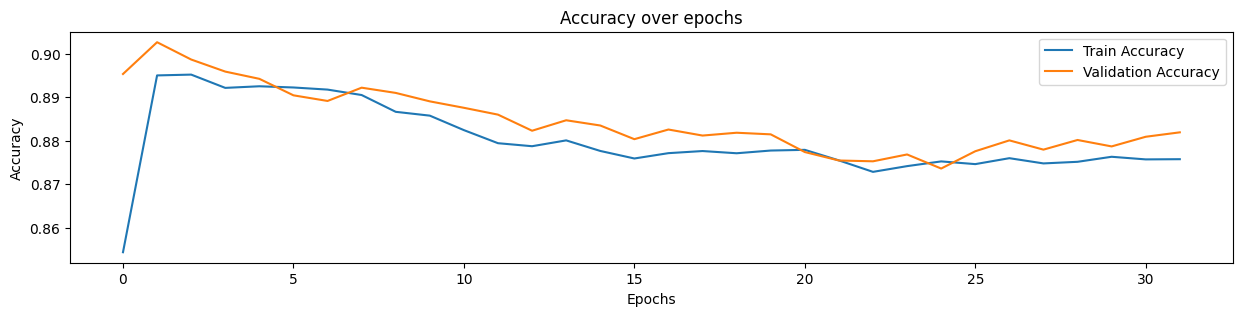

In [37]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_studentQPKD.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

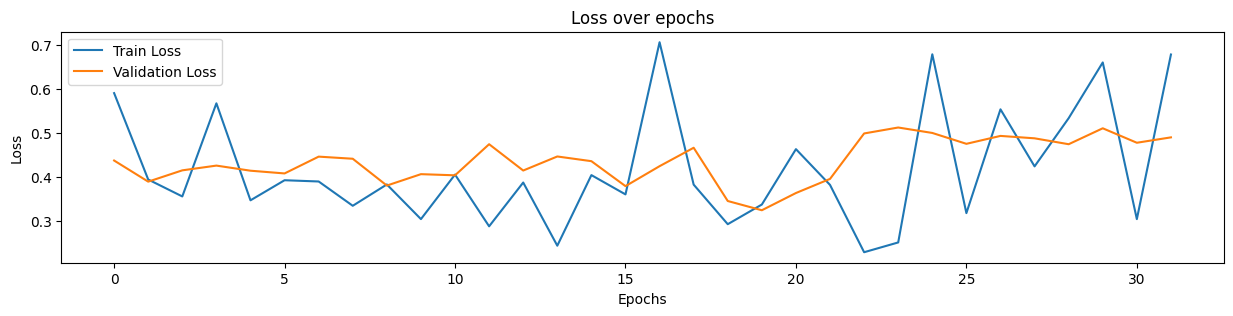

In [38]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['student_loss'], label='Train Loss')
plt.plot(history_studentQPKD.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

313/313 [==============================] - 1s 2ms/step


<Figure size 700x700 with 0 Axes>

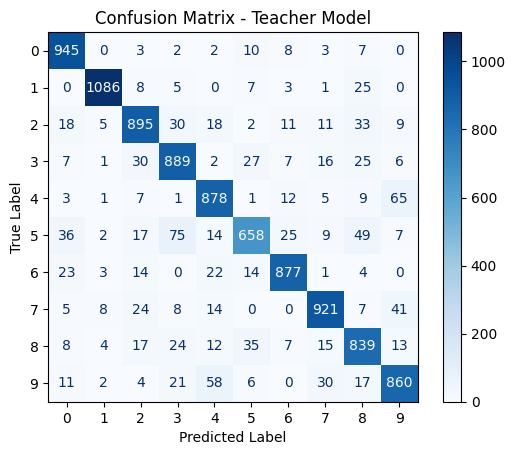

In [39]:
# 1. Predecir probabilidades
y_pred_probs =distilled_student.student.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [40]:
student_only = distilled_student.student

test_labels = np.argmax(y_test, axis=1)

student_only.predict(x_test)


313/313 [==============================] - 1s 5ms/step


array([[7.8540470e-05, 1.1876087e-04, 2.4611416e-04, ..., 9.9407446e-01,
        2.3414602e-04, 2.9495938e-03],
       [1.1981541e-03, 1.9281014e-03, 9.6441036e-01, ..., 1.9217342e-04,
        3.3433260e-03, 8.3638530e-05],
       [1.2716745e-06, 9.7085041e-01, 9.2021320e-03, ..., 1.2331805e-04,
        1.8347939e-03, 1.3350352e-04],
       ...,
       [2.6584325e-07, 1.3453042e-04, 8.5831416e-04, ..., 1.8496910e-02,
        2.5733458e-03, 1.7140496e-01],
       [8.1978949e-05, 2.2067893e-03, 9.4588968e-04, ..., 5.1125291e-05,
        6.4260013e-02, 8.9331216e-04],
       [7.2848778e-03, 4.4412427e-05, 2.5062328e-02, ..., 7.3473297e-05,
        7.6184527e-04, 7.4104937e-05]], dtype=float32)

1/1 [==============================] - 0s 29ms/step
Label real: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Predicción: 4
Probabilidades: [[2.6201681e-07 4.5127312e-05 1.2338546e-03 2.3657572e-03 7.9161185e-01
  7.2719628e-04 6.5245375e-05 3.4241766e-02 7.7110203e-04 1.6893783e-01]]


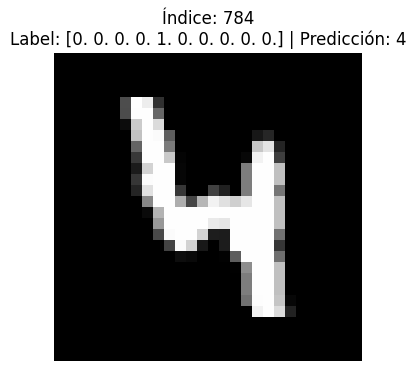

In [41]:
import numpy as np
import matplotlib.pyplot as plt

indexPrediction = 784

# Sacas el vector aplanado (784,)
x_input = x_test[indexPrediction]
y_label = y_test[indexPrediction]

# Para el modelo: necesita (1, 784)
inputPred = np.expand_dims(x_input, axis=0)

# Predicción
y_pred = distilled_student.student.predict(inputPred)
pred_class = np.argmax(y_pred)

print("Label real:", y_label)
print("Predicción:", pred_class)
print("Probabilidades:", y_pred)

# --- Graficar la imagen reconstruida ---
img_2d = x_input.reshape(28, 28)   # <---- ¡IMPORTANTE!

plt.figure(figsize=(4,4))
plt.imshow(img_2d, cmap='gray')
plt.title(f"Índice: {indexPrediction}\nLabel: {y_label} | Predicción: {pred_class}")
plt.axis('off')
plt.show()


In [42]:
model = strip_pruning(distilled_student.student)
model.summary()
model.save('models/MLP/studentModelMnistMLP.h5')

Model: "studentMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 64)                50240     
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 fc2 (QDense)                (None, 32)                2080      
                                                                 
 relu2 (QActivation)         (None, 32)                0         
                                                                 
 drop1 (Dropout)             (None, 32)                0         
                                                                 
 output (QDense)             (None, 10)                330       
                                                                 
 outputActivation (Activatio  (None, 10)               0